# Multimodal Late Fusion Model
## Text + Tabular + Image embeddings -> SVM + XGBoost

## 0) Imports

In [11]:
import os
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.svm import LinearSVC

from xgboost import XGBClassifier

import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Embedding, Bidirectional, LSTM,
    Dense, Dropout, BatchNormalization,
    GlobalAveragePooling1D, GlobalMaxPooling1D,
    Concatenate
)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

## 1) Configuration

In [2]:
df = pd.read_csv("FoodFactsCleaned.csv")
df["nutriscore_letter"] = df["nutriscore_letter"].astype(int)

In [3]:
TEXT_COLS = [ 
    "brand_cleaned",
    "allergens_cleaned",
    "ingredients_text_cleaned",
    "countries_cleaned",
    "additives_cleaned",
]

TABULAR_COLS = [
    'nova_group', 'fat_100g',
    'saturated_fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g',
    'proteins_100g', 'contains_palm_oil', 'vegetarian_status', 'vegan_status',
    'nutrient_level_fat', 'nutrient_level_saturated_fat',
    'nutrient_level_sugars', 'nutrient_level_salt', 'ecoscore_grade', 'ecoscore_score',
    'carbon_footprint_100g', 'additives_count', 'sugar_ratio',
    'energy_density', 'protein_ratio', 'macro_balance', 'healthy_score',
    'log_energy_kcal_100g', 'log_salt_100g'
]

TARGET_COL = "nutriscore_letter"           
IMAGE_COL = "image_160_path"

RANDOM_STATE = 42
TEST_SIZE = 0.2

# Text tokenization
MAX_WORDS = 30000
MAX_LEN = 200

# Image settings
IMG_SIZE = (160, 160)

# NN training
EPOCHS_TEXT = 10
EPOCHS_TAB  = 25
EPOCHS_IMG  = 10
BATCH_SIZE = 64

## 2) Basic checks + building concatenated text

In [4]:
needed = TEXT_COLS + TABULAR_COLS + [TARGET_COL, IMAGE_COL]
missing = [c for c in needed if c not in df.columns]
if missing:
    raise ValueError(f"Missing columns in df: {missing}")

for c in TEXT_COLS:
    df[c] = df[c].fillna("").astype(str)

df["text_concat"] = df[TEXT_COLS].agg(" ".join, axis=1)

df = df[df[IMAGE_COL].notna()].copy()
df = df[df[IMAGE_COL].astype(str).str.len() > 0].copy()
df = df[df[IMAGE_COL].apply(lambda p: os.path.exists(str(p)))].copy()

print("Rows after filtering invalid image paths:", len(df))

Rows after filtering invalid image paths: 5138


## 3) Unified Data Splitting across Modalities

In [6]:
X_text = df["text_concat"].values
X_tab  = df[TABULAR_COLS].values.astype(np.float32)
X_img  = df[IMAGE_COL].astype(str).values
y_raw  = df[TARGET_COL].values

if y_raw.dtype == object or isinstance(y_raw[0], str):
    le = LabelEncoder()
    y = le.fit_transform(y_raw)
else:
    y = y_raw.astype(int)

num_classes = len(np.unique(y))
print("Classes:", num_classes)

X_text_tr, X_text_te, X_tab_tr, X_tab_te, X_img_tr, X_img_te, y_tr, y_te = train_test_split(
    X_text, X_tab, X_img, y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y
)

print("Train:", len(y_tr), "Test:", len(y_te))

Classes: 5
Train: 4110 Test: 1028


## Text & Tabular Data Preprocessing

In [7]:
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(X_text_tr)

seq_tr = tokenizer.texts_to_sequences(X_text_tr)
seq_te = tokenizer.texts_to_sequences(X_text_te)

X_text_tr_pad = pad_sequences(seq_tr, maxlen=MAX_LEN, padding="post", truncating="post")
X_text_te_pad = pad_sequences(seq_te, maxlen=MAX_LEN, padding="post", truncating="post")

vocab_size = min(MAX_WORDS, len(tokenizer.word_index) + 1)
print("Vocab size:", vocab_size)

scaler = StandardScaler()
X_tab_tr_sc = scaler.fit_transform(X_tab_tr).astype(np.float32)
X_tab_te_sc = scaler.transform(X_tab_te).astype(np.float32)

tab_dim = X_tab_tr_sc.shape[1]
print("Tab dim:", tab_dim)

Vocab size: 14981
Tab dim: 25


## Image loading & preprocessing

In [8]:
def load_and_preprocess_image(path):
    img_bytes = tf.io.read_file(path)
    img = tf.io.decode_image(img_bytes, channels=3, expand_animations=False)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32)
    img = mobilenet_preprocess(img)
    return img

def make_img_ds(paths, labels, batch_size=64, training=True):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))

    def _map(p, y_):
        return load_and_preprocess_image(p), y_
    
    ds = ds.map(_map, num_parallel_calls=tf.data.AUTOTUNE)
    if training:
        ds = ds.shuffle(2048, seed=RANDOM_STATE, reshuffle_each_iteration=True)

    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

img_train_ds = make_img_ds(X_img_tr, y_tr, batch_size=32, training=True)
img_test_ds  = make_img_ds(X_img_te, y_te, batch_size=32, training=False)

## 6) Modality-specific models

### 6A) TEXT model: BiLSTM + pooling -> embedding

In [34]:
from tensorflow.keras.layers import SpatialDropout1D

def build_text_model(vocab_size, max_len, num_classes, embed_dim=42):
    text_in = Input(shape=(max_len,), dtype=tf.int32, name="text_in")

    x = Embedding(vocab_size, embed_dim, name="txt_embed")(text_in)
    x = SpatialDropout1D(0.2)(x)

    avg_pool = GlobalAveragePooling1D(name="txt_gap")(x)
    max_pool = GlobalMaxPooling1D(name="txt_gmp")(x)
    x = Concatenate(name="txt_pool_concat")([avg_pool, max_pool])

    x = Dense(128, activation="relu")(x)
    x = Dropout(0.4)(x)

    x = Dense(64, activation="relu", name="txt_embed_dense")(x)
    x = Dropout(0.3)(x)

    out = Dense(num_classes, activation="softmax", name="txt_out")(x)

    model = Model(inputs=text_in, outputs=out)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

text_model = build_text_model(vocab_size, MAX_LEN, num_classes)
text_model.summary()

text_model.fit(
    X_text_tr_pad, y_tr,
    validation_split=0.2,
    epochs=EPOCHS_TEXT,
    batch_size=BATCH_SIZE,
    callbacks=[
        EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True),
        ReduceLROnPlateau(monitor="val_loss", patience=1, factor=0.5, min_lr=1e-6)
    ],
    verbose=1
)

text_extractor = Model(
    inputs=text_model.input,
    outputs=text_model.get_layer("txt_embed_dense").output
)

Z_txt_tr = text_extractor.predict(X_text_tr_pad, batch_size=256, verbose=0)
Z_txt_te = text_extractor.predict(X_text_te_pad, batch_size=256, verbose=0)

print("Text embeddings:", Z_txt_tr.shape, Z_txt_te.shape)

Model: "functional_34"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_in             │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ txt_embed           │ (None, 200, 42)   │    629,202 │ text_in[0][0]     │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d_1 │ (None, 200, 42)   │          0 │ txt_embed[0][0]   │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ txt_gap             │ (None, 42)        │          0 │ spatial_dropout1… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ txt_gmp             │ (None, 42)        │          0 │ spatial_dropout1… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ txt_pool_concat     │ (None, 84)        │          0 │ txt_gap[0][0],    │
│ (Concatenate)       │                   │            │ txt_gmp[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 128)       │     10,880 │ txt_pool_concat[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_23          │ (None, 128)       │          0 │ dense_6[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ txt_embed_dense     │ (None, 64)        │      8,256 │ dropout_23[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_24          │ (None, 64)        │          0 │ txt_embed_dense[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ txt_out (Dense)     │ (None, 5)         │        325 │ dropout_24[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 648,663 (2.47 MB)

 Trainable params: 648,663 (2.47 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.2241 - loss: 1.6022 - val_accuracy: 0.2117 - val_loss: 1.5852 - learning_rate: 0.0010
Epoch 2/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.3166 - loss: 1.5241 - val_accuracy: 0.4075 - val_loss: 1.3844 - learning_rate: 0.0010
Epoch 3/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.3802 - loss: 1.3885 - val_accuracy: 0.4501 - val_loss: 1.2788 - learning_rate: 0.0010
Epoch 4/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4443 - loss: 1.2612 - val_accuracy: 0.5134 - val_loss: 1.1468 - learning_rate: 0.0010
Epoch 5/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4945 - loss: 1.1346 - val_accuracy: 0.5462 - val_loss: 1.0821 - learning_rate: 0.0010
Epoch 6/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5477 - loss: 1.0443 - val_accuracy: 0.5742 - val_loss: 1.0206 - learning_rate: 0.0010
Epoch 7/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5867 - loss: 0.9538 - val_acc

### 6B) TABULAR model: MLP -> embedding

In [26]:
def build_tabular_model(tab_dim, num_classes):
    tab_in = Input(shape=(tab_dim,), dtype=tf.float32, name="tab_in")

    x = BatchNormalization()(tab_in)

    x = Dense(256, activation="relu")(x)
    x = Dropout(0.35)(x)
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.25)(x)

    emb = Dense(128, activation="relu", name="tab_embedding")(x)
    emb = Dropout(0.25)(emb)

    out = Dense(num_classes, activation="softmax", name="tab_out")(emb)

    model = Model(inputs=tab_in, outputs=out)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

tab_model = build_tabular_model(tab_dim, num_classes)
tab_model.summary()


tab_model.fit(
    X_tab_tr_sc, y_tr,
    validation_split=0.2,
    epochs=EPOCHS_TAB,
    batch_size=128,
    callbacks=[
        EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
        ReduceLROnPlateau(monitor="val_loss", patience=2, factor=0.5, min_lr=1e-6)
    ],
    verbose=1
)


tab_extractor = Model(
    inputs=tab_model.input,
    outputs=tab_model.get_layer("tab_embedding").output
)

Z_tab_tr = tab_extractor.predict(X_tab_tr_sc, batch_size=256, verbose=0)
Z_tab_te = tab_extractor.predict(X_tab_te_sc, batch_size=256, verbose=0)

print("Tabular embeddings:", Z_tab_tr.shape, Z_tab_te.shape)

Model: "functional_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ tab_in (InputLayer)             │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 25)             │           100 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │         6,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ tab_embedding (Dense)           │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ tab_out (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,809 (221.91 KB)

 Trainable params: 56,759 (221.71 KB)

 Non-trainable params: 50 (200.00 B)

Epoch 1/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.4398 - loss: 1.3233 - val_accuracy: 0.6034 - val_loss: 0.9532 - learning_rate: 0.0010
Epoch 2/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6074 - loss: 0.9200 - val_accuracy: 0.6825 - val_loss: 0.7560 - learning_rate: 0.0010
Epoch 3/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6615 - loss: 0.7969 - val_accuracy: 0.7287 - val_loss: 0.6545 - learning_rate: 0.0010
Epoch 4/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6977 - loss: 0.7413 - val_accuracy: 0.7287 - val_loss: 0.6347 - learning_rate: 0.0010
Epoch 5/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6931 - loss: 0.7114 - val_accuracy: 0.7530 - val_loss: 0.6081 - learning_rate: 0.0010
Epoch 6/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7235 - loss: 0.6689 - val_accuracy: 0.7470 - val_loss: 0.5912 - learning_rate: 0.0010
Epoch 7/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7269 - loss: 0.6651 - val_accura

### 6C) IMAGE model: pretrained CNN + small head -> embedding

In [27]:
def build_image_model(num_classes):
    base = MobileNetV2(weights="imagenet", include_top=False, pooling="avg")
    base.trainable = False

    img_in = Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3), dtype=tf.float32, name="img_in")
    x = base(img_in)
    x = Dense(256, activation="relu")(x)
    x = Dropout(0.35)(x)

    emb = Dense(128, activation="relu", name="img_embedding")(x)
    emb = Dropout(0.25)(emb)

    out = Dense(num_classes, activation="softmax", name="img_out")(emb)

    model = Model(inputs=img_in, outputs=out)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

img_model = build_image_model(num_classes)
img_model.summary()

img_model.fit(
    img_train_ds,
    validation_data=img_test_ds,
    epochs=EPOCHS_IMG,
    callbacks=[
        EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True),
        ReduceLROnPlateau(monitor="val_loss", patience=1, factor=0.5, min_lr=1e-6)
    ],
    verbose=1
)

img_extractor = Model(
    inputs=img_model.input,
    outputs=img_model.get_layer("img_embedding").output
)

Z_img_tr = img_extractor.predict(img_train_ds, verbose=0)
Z_img_te = img_extractor.predict(img_test_ds, verbose=0)

print("Image embeddings:", Z_img_tr.shape, Z_img_te.shape)

C:\Users\HFCS\AppData\Local\Temp\ipykernel_16424\2791767440.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base = MobileNetV2(weights="imagenet", include_top=False, pooling="avg")


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 5s 1us/step


Model: "functional_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ img_in (InputLayer)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ img_embedding (Dense)           │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ img_out (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,619,461 (9.99 MB)

 Trainable params: 361,477 (1.38 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 77s 457ms/step - accuracy: 0.2557 - loss: 1.6690 - val_accuracy: 0.3171 - val_loss: 1.5144 - learning_rate: 0.0010
Epoch 2/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 50s 383ms/step - accuracy: 0.3287 - loss: 1.5058 - val_accuracy: 0.3093 - val_loss: 1.5122 - learning_rate: 0.0010
Epoch 3/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 45s 339ms/step - accuracy: 0.3438 - loss: 1.4843 - val_accuracy: 0.3434 - val_loss: 1.4903 - learning_rate: 0.0010
Epoch 4/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 48s 366ms/step - accuracy: 0.3798 - loss: 1.4203 - val_accuracy: 0.3482 - val_loss: 1.4635 - learning_rate: 0.0010
Epoch 5/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 46s 353ms/step - accuracy: 0.3844 - loss: 1.3976 - val_accuracy: 0.3531 - val_loss: 1.4658 - learning_rate: 0.0010
Epoch 6/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 45s 345ms/step - accuracy: 0.4341 - loss: 1.3167 - val_accuracy: 0.3560 - val_loss: 1.4448 - learning_rate: 5.0000e-04
Epoch 7/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 45s 340ms/step - accuracy:

## 7) Feature-level fusion: concatenate embeddings

In [28]:
X_fused_tr = np.hstack([Z_txt_tr, Z_tab_tr, Z_img_tr])
X_fused_te = np.hstack([Z_txt_te, Z_tab_te, Z_img_te])

print("Fused feature shape:", X_fused_tr.shape, X_fused_te.shape)

Fused feature shape: (4110, 320) (1028, 320)


In [29]:
svm = LinearSVC(C=1.0, class_weight="balanced", random_state=RANDOM_STATE)
svm.fit(X_fused_tr, y_tr)
svm_pred = svm.predict(X_fused_te)

print("\n=== Final Classifier: Linear SVM on fused embeddings ===")
print("Accuracy:", accuracy_score(y_te, svm_pred))
print("Macro-F1:", f1_score(y_te, svm_pred, average="macro"))
print(classification_report(y_te, svm_pred))


=== Final Classifier: Linear SVM on fused embeddings ===
Accuracy: 0.7928015564202334
Macro-F1: 0.7915779590783952
              precision    recall  f1-score   support

           0       0.83      0.80      0.81       193
           1       0.76      0.74      0.75       197
           2       0.72      0.78      0.75       210
           3       0.73      0.78      0.75       197
           4       0.93      0.86      0.89       231

    accuracy                           0.79      1028
   macro avg       0.79      0.79      0.79      1028
weighted avg       0.80      0.79      0.79      1028



In [30]:
xgb = XGBClassifier(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    objective="multi:softmax" if num_classes > 2 else "binary:logistic",
    num_class=num_classes if num_classes > 2 else None,
    eval_metric="mlogloss" if num_classes > 2 else "logloss",
    random_state=RANDOM_STATE,
    n_jobs=-1
)

xgb.fit(X_fused_tr, y_tr)
xgb_pred = xgb.predict(X_fused_te)

print("\n=== Final Classifier: XGBoost on fused embeddings ===")
print("Accuracy:", accuracy_score(y_te, xgb_pred))
print("Macro-F1:", f1_score(y_te, xgb_pred, average="macro"))
print(classification_report(y_te, xgb_pred))


=== Final Classifier: XGBoost on fused embeddings ===
Accuracy: 0.811284046692607
Macro-F1: 0.8102315223777572
              precision    recall  f1-score   support

           0       0.88      0.78      0.82       193
           1       0.74      0.78      0.76       197
           2       0.75      0.79      0.77       210
           3       0.76      0.82      0.79       197
           4       0.94      0.87      0.91       231

    accuracy                           0.81      1028
   macro avg       0.81      0.81      0.81      1028
weighted avg       0.82      0.81      0.81      1028



In [31]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np

# -------- SVM --------
svm_train_pred = svm.predict(X_fused_tr)
svm_test_pred  = svm.predict(X_fused_te)

svm_train_acc = accuracy_score(y_tr, svm_train_pred)
svm_test_acc  = accuracy_score(y_te, svm_test_pred)

# -------- XGBoost --------
xgb_train_pred = xgb.predict(X_fused_tr)
xgb_test_pred  = xgb.predict(X_fused_te)

xgb_train_acc = accuracy_score(y_tr, xgb_train_pred)
xgb_test_acc  = accuracy_score(y_te, xgb_test_pred)

print("SVM  -> Train Acc:", svm_train_acc, " Test Acc:", svm_test_acc)
print("XGB  -> Train Acc:", xgb_train_acc, " Test Acc:", xgb_test_acc)


SVM  -> Train Acc: 0.9250608272506082  Test Acc: 0.7928015564202334
XGB  -> Train Acc: 1.0  Test Acc: 0.811284046692607


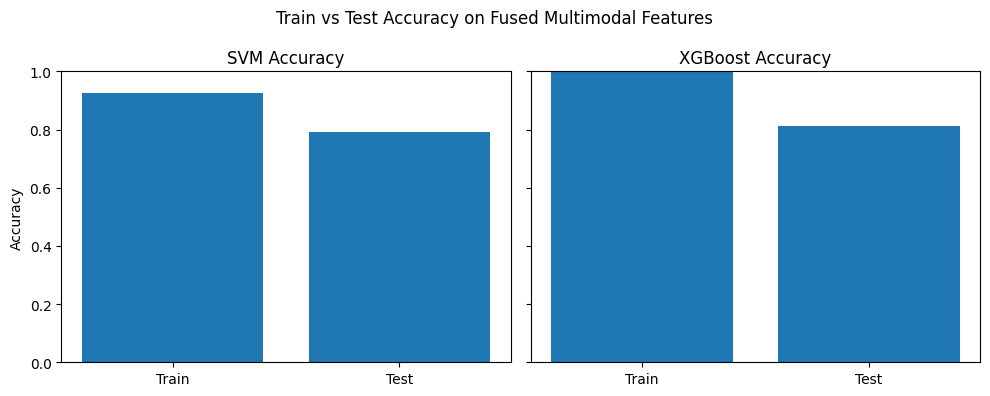

In [32]:
models = ["SVM", "XGBoost"]
train_acc = [svm_train_acc, xgb_train_acc]
test_acc  = [svm_test_acc,  xgb_test_acc]

x = np.arange(len(models))
width = 0.35

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

# ---- SVM subplot ----
axes[0].bar(["Train", "Test"], [svm_train_acc, svm_test_acc])
axes[0].set_title("SVM Accuracy")
axes[0].set_ylabel("Accuracy")
axes[0].set_ylim(0, 1)

# ---- XGBoost subplot ----
axes[1].bar(["Train", "Test"], [xgb_train_acc, xgb_test_acc])
axes[1].set_title("XGBoost Accuracy")
axes[1].set_ylim(0, 1)

plt.suptitle("Train vs Test Accuracy on Fused Multimodal Features")
plt.tight_layout()
plt.show()
